# FACE CLASSIFICATION AND RECOGNITION WITH TRANSFER LEARNING

### Importing dependencies 

In [29]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from sklearn.metrics import classification_report
%matplotlib inline 

### Uploading our dataset

In [2]:
#uploading the dataset of faces for the tennis players we want our algorithm to recognise 
directory='./dataset'
batch_size=32
image_size=(224,224)
labels= ['carlos alcaraz', 'novak djokovic', 'rafael nadal', 'roger federer']
training_data = image_dataset_from_directory(directory,
                                             labels='inferred',
                                             label_mode='categorical',
                                             class_names=labels,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=image_size,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=1994)
validation_data= image_dataset_from_directory(directory,
                                             labels='inferred',
                                             label_mode='categorical',
                                             class_names=labels,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=image_size,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=1994)

Found 498 files belonging to 4 classes.


Using 399 files for training.
Found 498 files belonging to 4 classes.
Using 99 files for validation.


### Displaying some images from our dataset 

(32, 224, 224, 3)


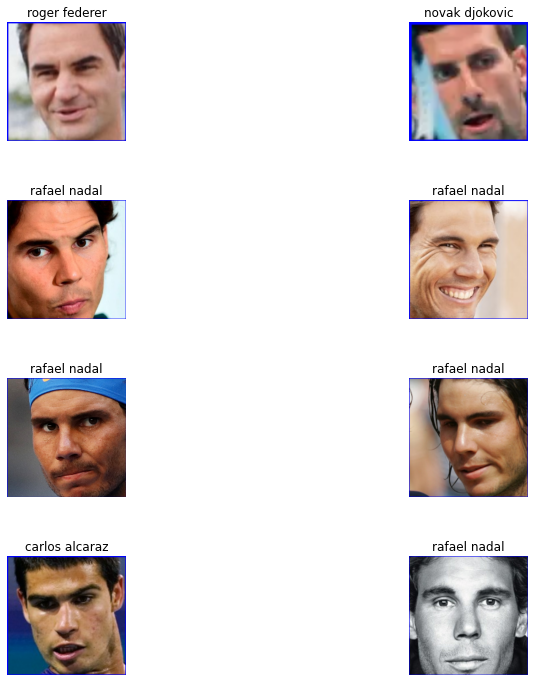

In [3]:
batch_num=1
num_img=8

def images_displayer(dataset,batch_num,num_img):
  """Helper function to display images
     dataset: dataset of images with labels
     batch_num: the number of the batch where to extract the image from
     num_img: number of images to display"""
  classes=dataset.class_names
  for images, labels in dataset.take(batch_num):
    print(images.numpy().shape)

    plt.figure(figsize=(12,12))
    for i in range(num_img):
      ax=plt.subplot(4,2,i+1)
      plt.imshow(images[i].numpy().astype("uint8")) 
      # the labels are one_hot_encoded
      plt.title(classes[np.argmax(labels[i])]) 
      plt.axis('off')
      plt.subplots_adjust(hspace=0.5, wspace=0.5)

images_displayer(training_data,batch_num,num_img)


### Loading the pretrained model weights to use it in our dataset for face classification purpose
 We will use VGGFace


In [4]:
# loading the model  VGGFace2 for the embeddings
#pip install git+https://github.com/rcmalli/keras-vggface.git. You will need to correct small errors in the source code. 
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input


##### Firstly we will preprocess the dataset using the preprocessing methods used to train VGGFace model

In [5]:
pre_training_data=validation_data.map(lambda x, y: (tf.numpy_function(preprocess_input, [x], tf.float32), y))
pre_validation_data=validation_data.map(lambda x, y: (tf.numpy_function(preprocess_input, [x], tf.float32), y))


In [13]:
#checking the dimension of the data 
image_batch=next(iter(pre_training_data))
print(image_batch[0].shape)
print(image_batch[1].shape)


(32, 224, 224, 3)
(32, 4)


We will delete the top layer from the pretrained model and add a new 
classifier layer for our problem: 4 neurons as we need to classify the images of 4 tennis players

In [14]:
input_shape=(224,224,3)
model=VGGFace(model='resnet50',include_top=False,input_shape=input_shape)
model.trainable=False
#checking the dimensionality  of the inputs and outputs of the pretained model 
print(model.inputs)
model.output


[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>]


<KerasTensor: shape=(None, 1, 1, 2048) dtype=float32 (created by layer 'avg_pool')>

### Building our model

In [15]:
#create the input layer 
inputs=tf.keras.Input(shape=(224,224,3))
x=layers.Rescaling(1./255, input_shape=input_shape)(inputs)
x=layers.RandomRotation(factor=0.2)(x)
x=layers.RandomFlip(mode="horizontal")(x)
x=model(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(32, activation='relu')(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(rate=0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 132 

In [17]:
learning_rate=0.001
#optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.RMSprop(learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
#Early stopping to avoid overfitting of model
from keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
epochs=10
history=model.fit(training_data,validation_data=validation_data,epochs=epochs,callbacks=[early_stop])

Epoch 1/10


13/13 [==============================] - 53s 4s/step - loss: 1.0684 - accuracy: 0.8396 - val_loss: 0.0310 - val_accuracy: 1.0000
Epoch 2/10
13/13 [==============================] - 38s 3s/step - loss: 0.0582 - accuracy: 0.9774 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 3/10
13/13 [==============================] - 38s 3s/step - loss: 0.0298 - accuracy: 0.9875 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 44s 3s/step - loss: 0.0260 - accuracy: 0.9850 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 46s 4s/step - loss: 0.0217 - accuracy: 0.9900 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 43s 3s/step - loss: 0.0133 - accuracy: 0.9950 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 37s 3s/step - loss: 0.0305 - accuracy: 0.9900 - val_loss: 0.0121 - val_accuracy: 0.9899
Epoch 8/10
13/13 [=============

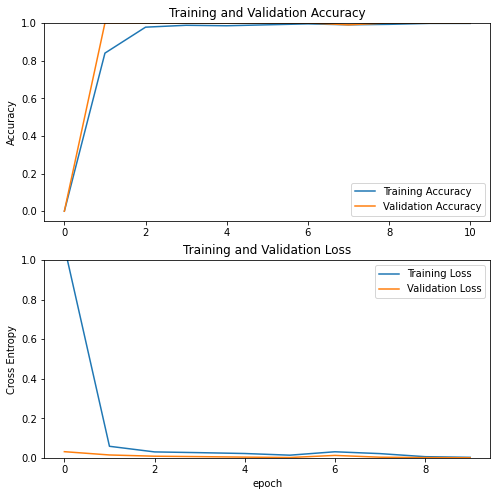

In [19]:
accuracy = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Summarising we can see that our model is performing  highly accuratly. It is learnign the underlying patterns in the data and generalsing very well to new data (validation data). We can conclude this after analysing: 

* Loss Decrease: The training loss consistetly decreasing. This suggests that the model is effectively adjusting its parameters to minimize the difference between predicted and actual values.

* High Accuracy: The training accuracy steadily increases reaching around 99.75% by the end of training indicates that the model is correctly classifying the training data with high precision.

* Validation Performance: Very low value of validation loss at the end of training. The validation accuracy reaches a perfect 1.0000 (100%). These metrics imply that the model is not only memorizing the training data but also generalizing well to unseen data.

* Consistency: The validation metrics consistently improve with each epoch, which is a positive sign. It suggests that the model is not overfitting (fitting too closely to the training data) and is indeed learning meaningful patterns.

However, it is recommendable to try the model with a completly new test dataset to see its performance

## Face recognition
- **Face verification**: In the context of face verification, the process involves two inputs: the individual's name or label, and an image capturing their face. The algorithm encodes this image and subsequently examines whether the resulting embedding corresponds to the entry stored in the database under the provided name.

- **Face recognition**: In the context of face recognition, a single input suffices (an image of a face). This image undergoes encoding through the algorithm, which then determines whether the encoded features match any entry within the database.

In [20]:
model1=VGGFace(model='resnet50',include_top=False,input_shape=input_shape)

In [21]:

def database_embedding(dataset, batch_num=3):
   """ This is a function that uses a pretrained model to encode the face of our 
      targets and store the encoded faces in a dictionary whose keys are the labels and the values 
      are the encoded image for each target. 
   
      inputs:
      dataset- dataset for creating our databases
      batch_num- the batch we want to extract the picture from
      """
 
   classes=training_data.class_names
   database={}
   
   for images, labels in dataset.take(batch_num):
      for i in range(len(images)):
         if classes[np.argmax(labels[i])] not in database.keys():
            database[classes[np.argmax(labels[i])]]=model1.predict_on_batch(np.expand_dims(images[i],axis=0))
         elif classes[np.argmax(labels[i])] in  database.keys() and len(database)<4:
            continue 
         else:
            break

   return database
         

In [44]:
database_embeddings=database_embedding(pre_training_data)
database_embeddings['carlos alcaraz'].shape

(1, 1, 1, 2048)

In [46]:
def inputs_encoding(dataset):
    """ This function uses a pretrained model to encode the images of the dataset and return
        the embedding images and the true_ labels for those images"""

    inputs_embeddings = []
    inputs_labels = []

    for images, labels in dataset:
        embeddings = model1.predict(images) 
        inputs_embeddings.append(embeddings)
        inputs_labels.append(labels)

    # Convert lists to NumPy arrays
    inputs_embeddings = np.concatenate(inputs_embeddings)
    inputs_labels = np.concatenate(inputs_labels, axis=0)

    return inputs_embeddings, np.argmax(inputs_labels,axis=1)


inputs_embeddings, inputs_labels= inputs_encoding(pre_validation_data)


1/1 [==============================] - 0s 135ms/step


In [47]:
#printing the shape of the input embeddings matrix, the shape of the labels array
print(inputs_embeddings.shape)
print(inputs_labels.shape)

(99, 1, 1, 2048)
(99,)


In [48]:

def recognise(database_embeddings,inputs_embeddings):
    """This function take as input the database with the encoded faces for our targets 
       and the encoded faces for the people we want to check if they are in our database. It
       returns a dataframe with the identities of the input faces and the distance metric"""
    treshold =0.6
    identities=[]
    distances=[]
    for image in inputs_embeddings:
        min_dist=500
        pred_label=''
        
        for name,_ in database_embeddings.items():
            dist=np.linalg.norm(tf.subtract(np.reshape(image,(1,-1)),
                                np.reshape(database_embeddings[name],(1,-1))),ord=2)/255.
            
            if dist< min_dist:
                min_dist=dist
                pred_label=name

        if min_dist<treshold:
            identities.append(pred_label)
            distances.append(min_dist)
                
        else:
            identities.append('not in database')
            distances.append(min_dist)
            
    output=pd.DataFrame({'identities':identities,'distance':distances})

    return output

In [49]:
identities=recognise(database_embeddings,inputs_embeddings)
identities

,identities,distance
0,rafael nadal,0.409853
1,carlos alcaraz,0.359873
2,carlos alcaraz,0.363888
3,carlos alcaraz,0.402114
4,novak djokovic,0.209192
...,...,...
94,roger federer,0.329839
95,carlos alcaraz,0.345725
96,carlos alcaraz,0.343976
97,carlos alcaraz,0.365254


In [50]:
#function to encode the classes for the predicted identities. 
classes=training_data.class_names 
label_encoder=lambda labels, classes: [classes.index(i) for i in labels]
identities_pred=np.array(label_encoder(identities.identities,classes))

In [51]:
identities_pred
inputs_labels

print(classification_report(inputs_labels,identities_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00        19
           3       1.00      0.97      0.99        34

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99



In [52]:
errors=0
for i in range(len(identities_pred)):
    if identities_pred[i]!= inputs_labels[i]:
        errors+=1

In [60]:
print(f' the error rate is {round(errors/len(identities_pred)*100,1)}% in the validation set')

 the error rate is 1.0% in the validation set


The model achieves a perfect precision of 1.00 for Class 0, Class 2, and Class 3, signifying that the predicted instances for these classes are all accurate and lacking of false positives.

For Class 1, the model shows a precision of 0.95, which still demonstrates a substantial level of accuracy in its predictions.

Furthermore, the recall scores are consistently high, indicating that the model effectively captures a significant proportion of the actual instances for each class. 

The F1 Score is really high too  and the overall accuracy is 99% 

### We can see the power of transfer learning. However, it's essential to be cautious while selecting a base model. Opting for a base model that has undergone training on a comparable task and dataset is pivotal. This choice dictates pivotal decisions, such as determining whether to retrain the base model, extend its capabilities, or fine-tune its parameters. Additionally, we need to have meassures in place to tackle overfitting if necessary. 